# IMPORTS

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import wandb
import os
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from skimage import color, io

# DATASET

Given images are in RBG format

In [2]:
def visualize_samples(input_dir, output_dir, json_path, num_samples=5):
    with open(json_path, 'r') as f:
        data = json.load(f)

    for i, item in enumerate(data[:num_samples]):
        input_filename = item["input_polygon"]
        output_filename = item["output_image"]
        color = item["colour"]

        input_image_path = os.path.join(input_dir, input_filename)
        output_image_path = os.path.join(output_dir, output_filename)

        input_image = Image.open(input_image_path)
        output_image = Image.open(output_image_path)

        plt.figure(figsize=(6, 3))
        plt.suptitle(f'Sample {i+1} - Color: {color}')
        plt.subplot(1, 2, 1)
        plt.imshow(input_image)
        plt.title('Input Polygon')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(output_image)
        plt.title('Colored Output')
        plt.axis('off')

        plt.tight_layout()
        plt.show()



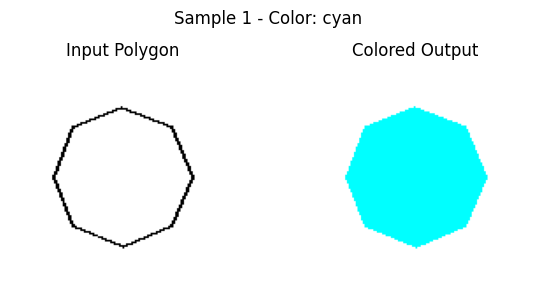

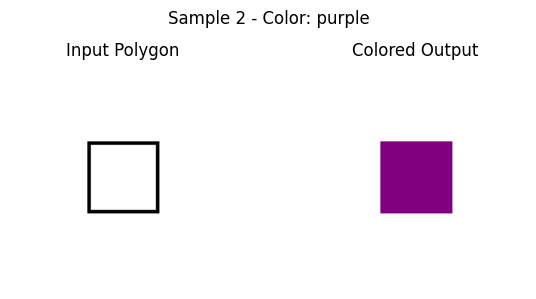

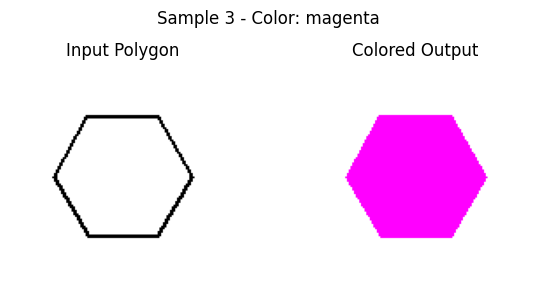

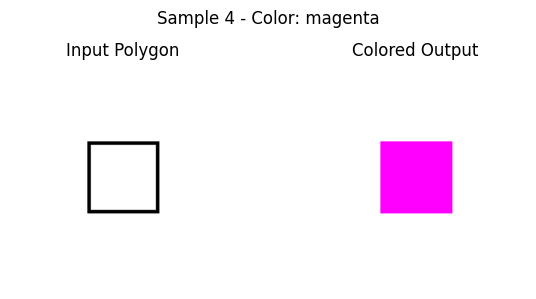

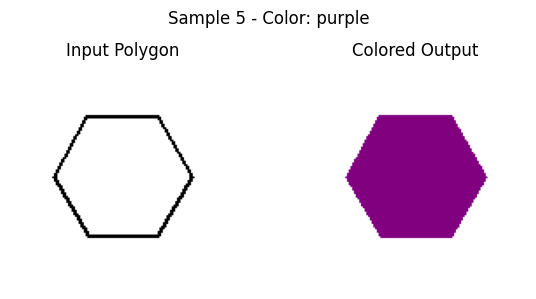

In [3]:
visualize_samples(
    input_dir='/kaggle/input/ayna-unet-dataset/dataset/training/inputs',
    output_dir='/kaggle/input/ayna-unet-dataset/dataset/training/outputs',
    json_path='/kaggle/input/ayna-unet-dataset/dataset/training/data.json',
    num_samples=5
)

In [4]:
train_json = '/kaggle/input/ayna-unet-dataset/dataset/training/data.json'
val_json = '/kaggle/input/ayna-unet-dataset/dataset/validation/data.json'

In [5]:
def count_colours(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    colours_list = [entry['colour'] for entry in data]
   

    return Counter(colours_list)

train_color_counts = count_colours(train_json)
val_color_counts = count_colours(val_json)

all_colors = sorted(set(train_color_counts.keys()).union(val_color_counts.keys()))

print("Color Counts in Training Set:")
for color in all_colors:
    print(f"{color}: {train_color_counts.get(color, 0)}")

print("\nColor Counts in Validation Set:")
for color in all_colors:
    print(f"{color}: {val_color_counts.get(color, 0)}")


Color Counts in Training Set:
blue: 7
cyan: 6
green: 7
magenta: 7
orange: 7
purple: 8
red: 8
yellow: 6

Color Counts in Validation Set:
blue: 1
cyan: 1
green: 1
magenta: 0
orange: 0
purple: 0
red: 0
yellow: 2


In [6]:


def extract_named_colors(json_path, base_path = '/kaggle/input/ayna-unet-dataset/dataset/training/outputs'):
    with open(json_path, 'r') as f:
        data = json.load(f)

    color_map = {}

    for item in data:
        color_name = item['colour']  # Adjust this key if necessary
        img_path = item['output_image']

        # Load image and convert to RGB
        img = Image.open(f'{base_path}/{img_path}').convert('RGB')
        img_np = np.array(img)

        # Get unique colors from the image (shape: (num_colors, 3))
        unique_colors = np.unique(img_np.reshape(-1, 3), axis=0)

        # Normalize colors (divide by 255)
        normalized_colors = (unique_colors / 255).round(3)


        norm_color_tensor = torch.tensor(normalized_colors[0].tolist())

        if color_name not in color_map:
            color_map[color_name] = norm_color_tensor
        else:
            # If a color_name already exists, you might want to verify the color is the same or update
            # Here we simply check if they match or raise a warning
            if not torch.allclose(color_map[color_name], norm_color_tensor):
                print(f"Warning: Multiple different colors found for '{color_name}'")
    
    return color_map


train_color_map = extract_named_colors(train_json)
colour_map = {}
for name, tensor_color in train_color_map.items():
    colour_map[name]= torch.tensor(tensor_color.tolist())

print("Normalized color map with names:")
colour_map

Normalized color map with names:


{'cyan': tensor([0., 1., 1.]),
 'purple': tensor([0.5020, 0.0000, 0.5020]),
 'magenta': tensor([1., 0., 1.]),
 'green': tensor([0., 1., 0.]),
 'red': tensor([1., 0., 0.]),
 'blue': tensor([0., 0., 1.]),
 'yellow': tensor([1., 1., 0.]),
 'orange': tensor([1.0000, 0.6470, 0.0000])}

In [7]:
class PolygonDataset(Dataset):
    def __init__(self, base_path,  colour_map, split='training', transform=None):
        self.base_path = base_path
        self.split = split
        self.transform = transform

        with open(f"{base_path}/{split}/data.json") as f:
            self.data = json.load(f)

        #Normalised colour channels - RGB
        self.color_map = colour_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_img = Image.open(f"{self.base_path}/{self.split}/inputs/{item['input_polygon']}")
        input_img = input_img.convert('L')  # Convert to grayscale

        # Load output image (colored polygon)
        output_img = Image.open(f"{self.base_path}/{self.split}/outputs/{item['output_image']}")
        output_img = output_img.convert('RGB')

        # Get color tensor
        colour = self.color_map[item['colour']]

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        return {
            'input': input_img,
            'colour': colour.float(),
            'output': output_img
        }

In [8]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Conditional_UNet(nn.Module):
    def init_weight(self, std=0.2):
        for m in self.modules():
            cn = m.__class__.__name__
            if cn.find('Conv') != -1:
                m.weight.data.normal_(0., std)
            elif cn.find('Linear') != -1:
                m.weight.data.normal_(1., std)
                m.bias.data.fill_(0)

    def __init__(self, in_ch = 1, out_ch = 3, c_embd = 1024):
        super(Conditional_UNet, self).__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.3)

        # Bottleneck
        self.bottleneck = double_conv(512, c_embd)

        # Upsample
        self.up1 = nn.ConvTranspose2d(c_embd, 512, 2, stride=2)
        self.up_conv1 = double_conv(c_embd, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv2 = double_conv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv3 = double_conv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv4 = double_conv(128, 64)

        # Final convolution
        self.final_conv = nn.Conv2d(64, out_ch, 1)
        self.color_fc = nn.Linear(out_ch, c_embd)
        
    def forward(self, x, color, c_embd=1024):
        c1 = self.dconv_down1(x)
        p1 = self.maxpool(c1)

        c2 = self.dconv_down2(p1)
        p2 = self.maxpool(c2)
    
        c3 = self.dconv_down3(p2)
        p3 = self.maxpool(c3)
    
        c4 = self.dconv_down4(p3)
        p4 = self.maxpool(c4)
    
        # Bottleneck with color conditioning
        bottleneck = self.bottleneck(p4)
    
        # Add color information
        color_embedding = self.color_fc(color).view(-1, c_embd, 1, 1)
        bottleneck = bottleneck + color_embedding
    
        # Decode
        u1 = self.up1(bottleneck)
        u1 = torch.cat([u1, c4], dim=1)
        u1 = self.up_conv1(u1)
    
        u2 = self.up2(u1)
        u2 = torch.cat([u2, c3], dim=1)
        u2 = self.up_conv2(u2)
    
        u3 = self.up3(u2)
        u3 = torch.cat([u3, c2], dim=1)
        u3 = self.up_conv3(u3)
    
        u4 = self.up4(u3)
        u4 = torch.cat([u4, c1], dim=1)
        u4 = self.up_conv4(u4)
    
        output = self.final_conv(u4)
        return torch.sigmoid(output)

In [23]:
def weighted_bce_loss(output, target, white_thresh_low=0.96, white_thresh_high=1, device='cuda'):

    white_mask = (target >= white_thresh_low) & (target <= white_thresh_high)  # boolean mask
    white_mask = white_mask.float().to(device)

    # Normal mask = 1 for non-white pixels
    normal_mask = 1.0 - white_mask
    bce_per_pixel = F.binary_cross_entropy(output, target, reduction='none')
    loss = bce_per_pixel * white_mask + 1.2 * bce_per_pixel * normal_mask

    return loss.mean()


# WANDB Tracking

In [26]:


# Model Setup
model = Conditional_UNet(in_ch=1, out_ch=3, c_embd=1024)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Cosine Annealing Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor()
])

train_dataset = PolygonDataset(base_path='/kaggle/input/ayna-unet-dataset/dataset', colour_map=colour_map, split='training', transform=transform)
val_dataset = PolygonDataset(base_path='/kaggle/input/ayna-unet-dataset/dataset', colour_map=colour_map, split='validation', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training Loop with Early Stopping
NUM_EPOCHS = 500
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

Number of GPUs: 1


In [13]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

wandb.login(key = secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: snehanshumukh (snehanshumukh-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [25]:

wandb.init(project="polygon-colorization", name="c_unet_weighted_bce_rgb_final")

wandb.config.update({
    "epochs": NUM_EPOCHS,
    "batch_size": 8,
    "lr": 1e-4,
    "loss_fn": "weightedbceloss",
    "model": "c_unet",
    "img_size": (256, 256)
})



epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,██▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,330
train_loss,0.05798
val_loss,0.03496


In [27]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        input_imgs = batch['input'].to(device)
        colors = batch['colour'].to(device)
        target_imgs = batch['output'].to(device)

        outputs = model(input_imgs, colors)
        loss = weighted_bce_loss(outputs, target_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch['input'].to(device)
            val_colors = val_batch['colour'].to(device)
            val_targets = val_batch['output'].to(device)

            val_outputs = model(val_inputs, val_colors)
            loss = weighted_bce_loss(val_outputs, val_targets)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    # Scheduler step
    scheduler.step()

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        #Save Model
        torch.save(model.state_dict(), "c_unet_weighted_bce_rgb.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Log losses
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
    })

    # Visualize every 30 epochs
    if (epoch + 1) % 10 == 0 or epoch == NUM_EPOCHS - 1:
        model.eval()
        def get_samples(loader, name):
            samples = []
            for i, batch in enumerate(loader):
                if i >= 1: break  # Only 1 batch
        
                inputs = batch['input'].to(device)
                colors = batch['colour'].to(device)
                targets = batch['output'].to(device)
                outputs = model(inputs, colors)
        
                for j in range(min(2, inputs.shape[0])):  # Handle small batch size
        
                    # Convert grayscale input [1, H, W] -> [H, W, 1]
                    img_input = inputs[j].detach().cpu().numpy().transpose(1, 2, 0)
                    gt = targets[j].detach().cpu().numpy().transpose(1, 2, 0)
                    pred = outputs[j].detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1)
        
                    # Ensure dtype is float32
                    img_input = img_input.astype('float32')
                    gt = gt.astype('float32')
                    pred = pred.astype('float32')
        
                    # Log 3 images per sample
                    samples.extend([
                        wandb.Image(img_input, caption=f"{name} Sample {j+1} - Input"),
                        wandb.Image(gt, caption=f"{name} Sample {j+1} - Ground Truth"),
                        wandb.Image(pred, caption=f"{name} Sample {j+1} - Prediction"),
                    ])
            return samples

        wandb.log({
            "Train Samples": get_samples(train_loader, "Train"),
            "Val Samples": get_samples(val_loader, "Val"),
        })


Epoch [1/500] - Train Loss: 0.7609, Val Loss: 0.7059
Epoch [2/500] - Train Loss: 0.7063, Val Loss: 0.6999
Epoch [3/500] - Train Loss: 0.6656, Val Loss: 0.6770
Epoch [4/500] - Train Loss: 0.6367, Val Loss: 0.6481
Epoch [5/500] - Train Loss: 0.6147, Val Loss: 0.6242
Epoch [6/500] - Train Loss: 0.5951, Val Loss: 0.6042
Epoch [7/500] - Train Loss: 0.5812, Val Loss: 0.5772
Epoch [8/500] - Train Loss: 0.5632, Val Loss: 0.5558
Epoch [9/500] - Train Loss: 0.5511, Val Loss: 0.5335
Epoch [10/500] - Train Loss: 0.5481, Val Loss: 0.5197
Epoch [11/500] - Train Loss: 0.5312, Val Loss: 0.4975
Epoch [12/500] - Train Loss: 0.5122, Val Loss: 0.4952
Epoch [13/500] - Train Loss: 0.5033, Val Loss: 0.4718
Epoch [14/500] - Train Loss: 0.4945, Val Loss: 0.4668
Epoch [15/500] - Train Loss: 0.4875, Val Loss: 0.4655
Epoch [16/500] - Train Loss: 0.4767, Val Loss: 0.4579
Epoch [17/500] - Train Loss: 0.4667, Val Loss: 0.4599
Epoch [18/500] - Train Loss: 0.4610, Val Loss: 0.4665
Epoch [19/500] - Train Loss: 0.4546, 

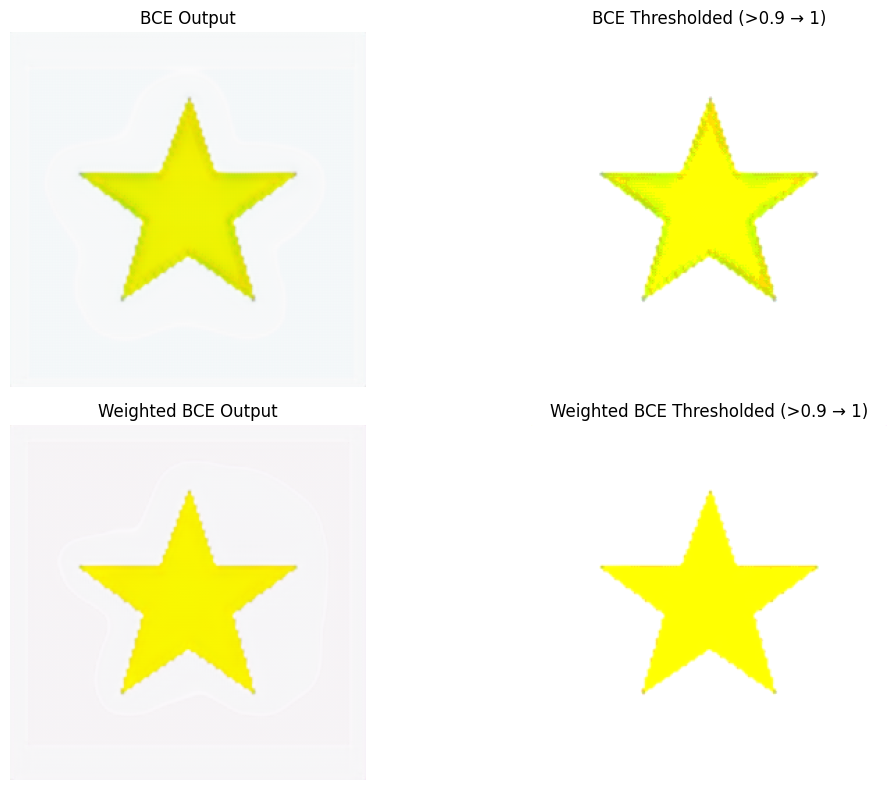

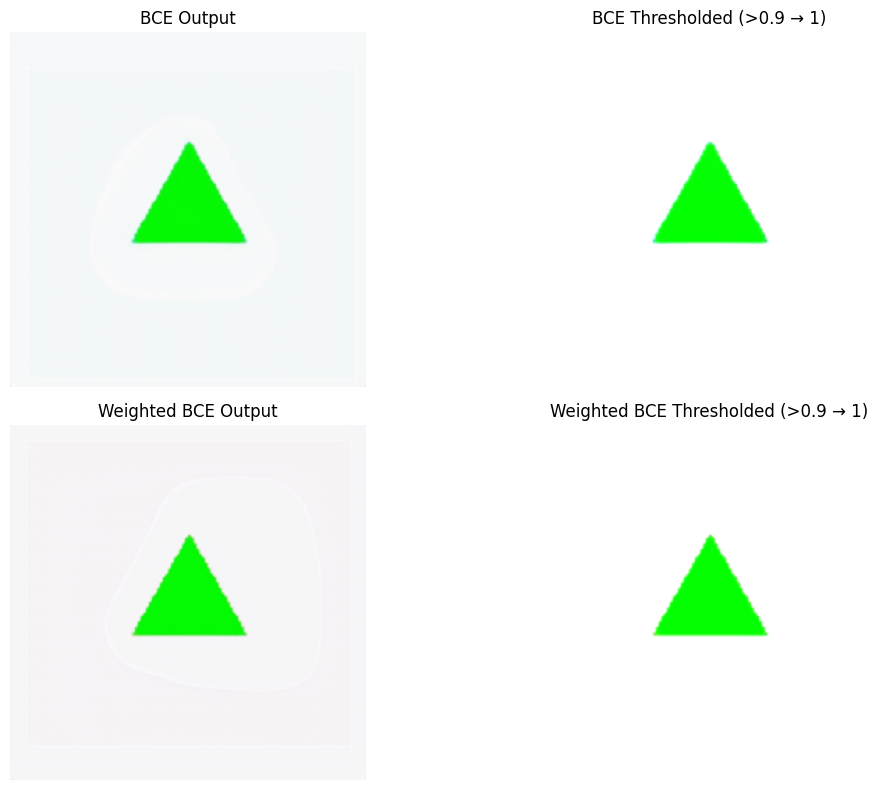

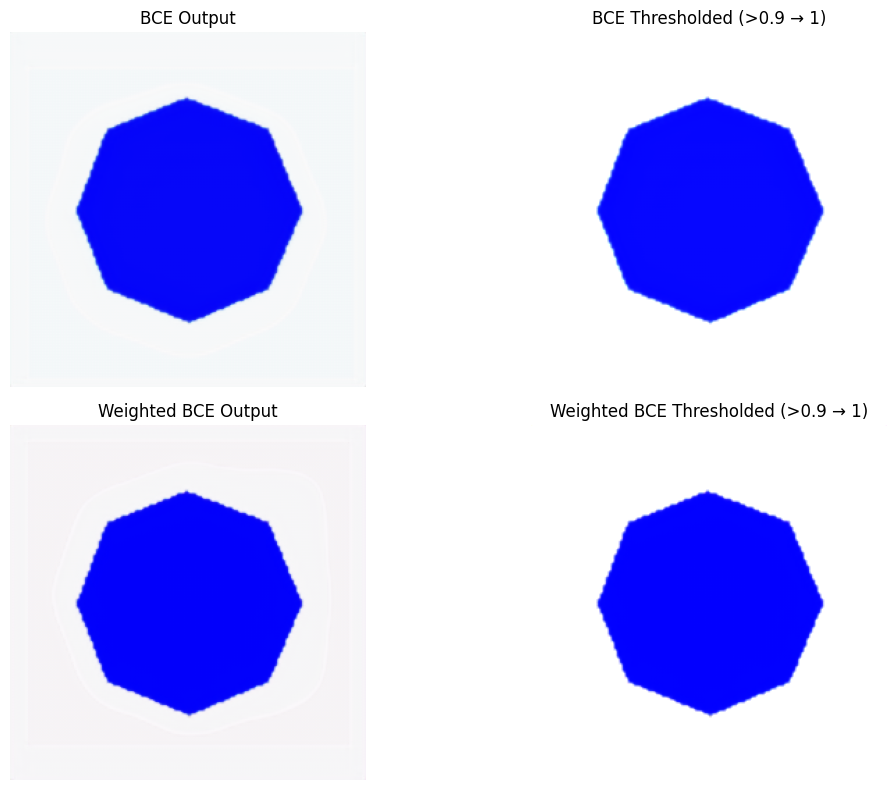

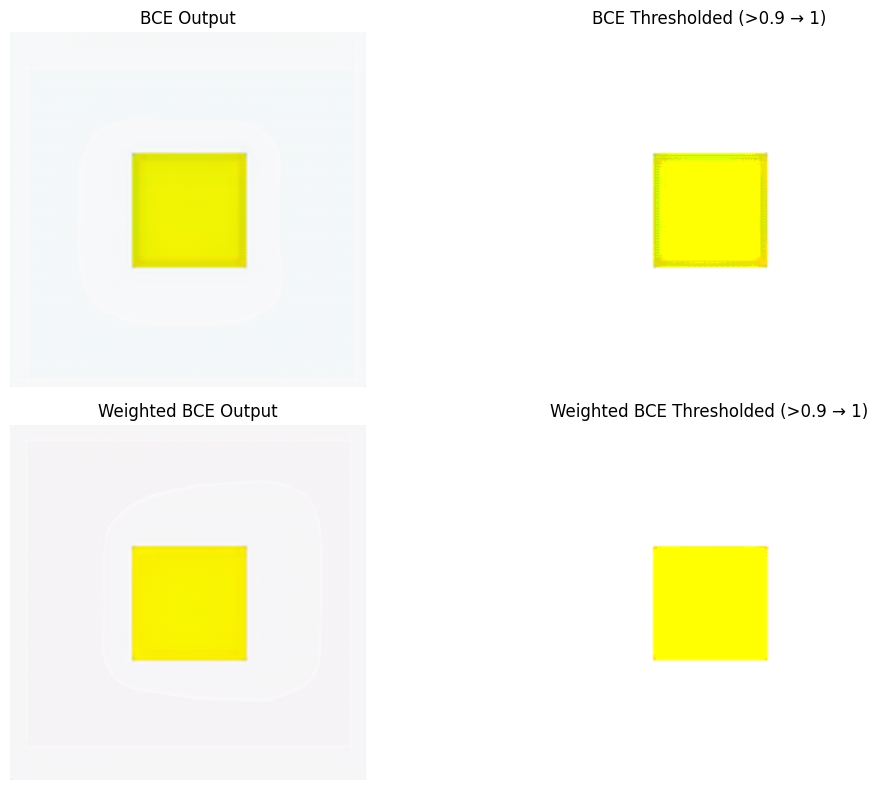

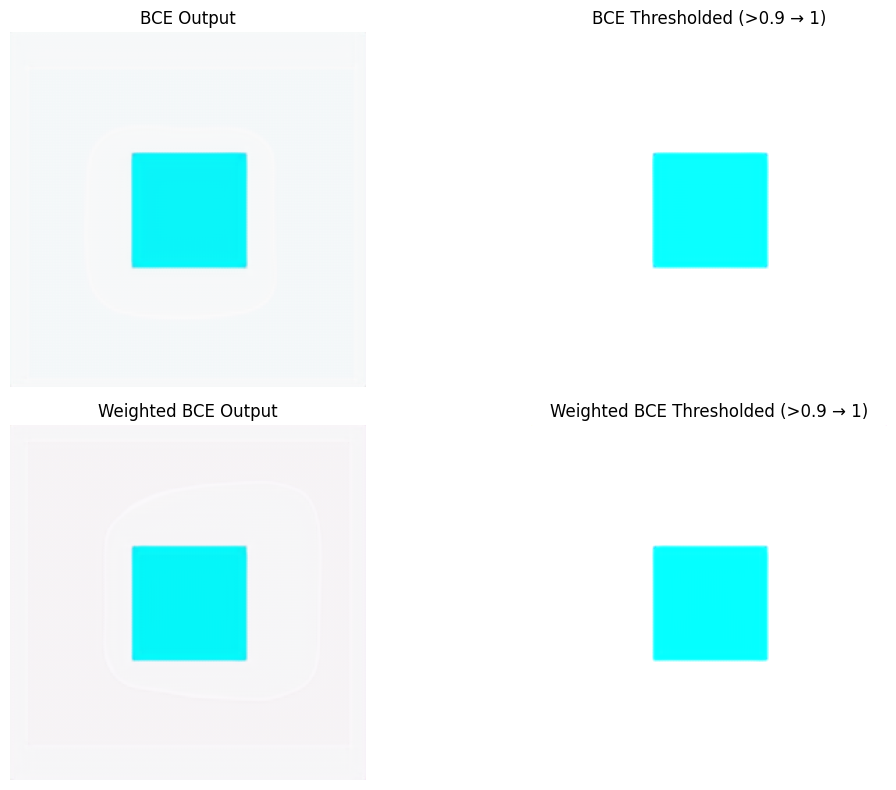

In [56]:
val_dataset = PolygonDataset(
    base_path='/kaggle/input/ayna-unet-dataset/dataset',
    colour_map=colour_map,
    split='validation',
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load both state dicts
state_dict_bce = torch.load("/kaggle/working/c_unet_bce_rgb.pth", map_location=device)
state_dict_w_bce = torch.load("/kaggle/working/c_unet_weighted_bce_rgb.pth", map_location=device)

# Reusable inference function
def get_model_outputs(state_dict):
    model = Conditional_UNet(in_ch=1, out_ch=3, c_embd=1024)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()

    all_outputs = []
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= 1:  # Just 1 batch
                break
            inputs = batch['input'].to(device)
            colors = batch['colour'].to(device)
            outputs = model(inputs, colors)
            all_outputs.append(outputs.cpu())
    return torch.cat(all_outputs, dim=0)

# Get model outputs
outputs_bce = get_model_outputs(state_dict_bce)
outputs_w_bce = get_model_outputs(state_dict_w_bce)

# Apply thresholding
outputs_bce_thresh = outputs_bce.clone()
outputs_bce_thresh[outputs_bce_thresh > 0.9] = 1.0

outputs_w_bce_thresh = outputs_w_bce.clone()
outputs_w_bce_thresh[outputs_w_bce_thresh > 0.9] = 1.0

# Visualize
for j in range(outputs_bce.shape[0]):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # BCE Output
    raw_bce = outputs_bce[j].permute(1, 2, 0).numpy().clip(0, 1)
    axes[0, 0].imshow(raw_bce)
    axes[0, 0].set_title('BCE Output')
    axes[0, 0].axis('off')

    thresh_bce = outputs_bce_thresh[j].permute(1, 2, 0).numpy().clip(0, 1)
    axes[0, 1].imshow(thresh_bce)
    axes[0, 1].set_title('BCE Thresholded (>0.9 → 1)')
    axes[0, 1].axis('off')

    # Weighted BCE Output
    raw_wbce = outputs_w_bce[j].permute(1, 2, 0).numpy().clip(0, 1)
    axes[1, 0].imshow(raw_wbce)
    axes[1, 0].set_title('Weighted BCE Output')
    axes[1, 0].axis('off')

    thresh_wbce = outputs_w_bce_thresh[j].permute(1, 2, 0).numpy().clip(0, 1)
    axes[1, 1].imshow(thresh_wbce)
    axes[1, 1].set_title('Weighted BCE Thresholded (>0.9 → 1)')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()
